In [1]:
"""
Purpose:
Now that have fully optimmized classifier, want to run it on test neurons to make sure runs all the way through
on a couple before I deploy it to Kubernetes
"""

'\nPurpose:\nNow that have fully optimmized classifier, want to run it on test neurons to make sure runs all the way through\non a couple before I deploy it to Kubernetes\n'

# Generating the Labels for each of the test neurons

In [2]:
from OPTIMIZED_whole_neuron_classifier_datajoint_adapted import extract_branches_whole_neuron as op_extract
from whole_neuron_classifier_datajoint_adapted import extract_branches_whole_neuron as unop_extract
import datajoint as dj
import numpy as np
import datajoint as dj
import trimesh
import time

dj.config["database.host"] = "10.28.0.34"
dj.config["database.user"] = "celiib"
dj.config["database.password"] = "newceliipass"
dj.config["safemode"] = True
dj.config["display.limit"] = 20

In [3]:
pinky = dj.create_virtual_module("pinky","microns_pinky")
schema = dj.schema("microns_pinky")

Connecting celiib@10.28.0.34:3306


In [4]:
key = dict(segmentation=3,segment_id=648518346349471910)
#key = dict(segmentation=3,segment_id=648518346349475536)


missing_apical_ids = [648518346349478700,648518346349485870]
not_missing_apicals = [648518346349473813,648518346349475510,648518346349473597] #but both have apicals
total_ids_to_test = missing_apical_ids + not_missing_apicals

In [5]:
#make the current key to use
index = 2
key = dict(segmentation=3,segment_id=total_ids_to_test[index])

In [ ]:
""" Do the labels from theh older version """
start_time = time.time()

print("\n\n*****Starting Auto Labeling for " + str(key["segment_id"]) + "******")

segment_id = key["segment_id"]

#get the vertices and faces from datajoint
# get the newly stitched mesh
# get the original mesh


verts,faces = (pinky.PymeshfixDecimatedExcitatoryStitchedMesh() & key).fetch1("vertices","triangles")

cgal_location = "/notebooks/Pass_2_Excitatory_4_Auto_Classifier_Whole_Neuron_Run_2/automatic_classifier_revised_efficiency/temp/"
cgal_file_sdf = str(key["segment_id"]) + "_fixed-cgal_3_0.20_sdf.csv"
cgal_file_seg = str(key["segment_id"]) + "_fixed-cgal_3_0.20.csv"

#run the whole algorithm on the neuron to test
verts_labels, faces_labels = unop_extract(import_Off_Flag=False,segment_id=segment_id,vertices=verts,
                     triangles=faces,pymeshfix_Flag=False,
                     import_CGAL_Flag=True,
                     import_CGAL_paths = [cgal_location + cgal_file_seg,
                                         cgal_location + cgal_file_sdf],
                     return_Only_Labels=True,
                     clusters=3,
                     smoothness=0.2)

print(f"Finished Auto Labeling: {time.time() - start_time}")


In [ ]:
# import importlib
# from OPTIMIZED_whole_neuron_classifier_datajoint_adapted import extract_branches_whole_neuron as op_extract
# importlib.reload(op_extract)


In [6]:
""" Do the labels from theh older version """
start_time = time.time()

print("\n\n*****Starting Auto Labeling for " + str(key["segment_id"]) + "******")

segment_id = key["segment_id"]

#get the vertices and faces from datajoint
# get the newly stitched mesh
# get the original mesh


verts,faces = (pinky.PymeshfixDecimatedExcitatoryStitchedMesh() & key).fetch1("vertices","triangles")

cgal_location = "/notebooks/Pass_2_Excitatory_4_Auto_Classifier_Whole_Neuron_Run_2/automatic_classifier_revised_efficiency/temp/"
cgal_file_sdf = str(key["segment_id"]) + "_fixed-cgal_3_0.20_sdf.csv"
cgal_file_seg = str(key["segment_id"]) + "_fixed-cgal_3_0.20.csv"

#run the whole algorithm on the neuron to test
verts_labels_opt, faces_labels_opt = op_extract(import_Off_Flag=False,segment_id=segment_id,vertices=verts,
                     triangles=faces,pymeshfix_Flag=False,
                     import_CGAL_Flag=True,
                     import_CGAL_paths = [cgal_location + cgal_file_seg,
                                         cgal_location + cgal_file_sdf],
                     return_Only_Labels=True,
                     clusters=3,
                     smoothness=0.2,
                     classifier_stub_threshold_apical=1500)

print(f"Finished Auto Labeling: {time.time() - start_time}")




*****Starting Auto Labeling for 648518346349473813******
1) Starting: Mesh importing and Pymesh fix
loading mesh from vertices and triangles array
1) Finished: Mesh importing and Pymesh fix: 0.2046494483947754
2) Staring: Generating CGAL segmentation for neuron
2) Finished: Generating CGAL segmentation for neuron: 40.653727293014526
3) Staring: Generating Graph Structure and Identifying Soma
soma_index = 0
3) Finished: Generating Graph Structure and Identifying Soma: 0.8996403217315674
5) Staring: Finding Apical Index
Soma Index = 0
Soma Connections = [92, 9, 11, 14, 36, 59, 16, 55, 283, 227, 208, 207, 217]
soma_80_percent = 285050.13125
possible_Axons_filter_1 = [11, 16]
size_threshold_filter = [11, 16]
height_threshold_filter = [11, 16]
sdf_threshold_filter = [11, 16]
possible_Axons_filter_2 = [11, 16]
STARTER picked_apical = 11 with highest connection 281737.59375
Next possible apical 16 with highest y 284055.75
possible_Apical = 11
5) Finished: Finding Apical Index: 2.14292359352

# COMPUTING THE CONFUSION MATRIX FOR BOTH OF THE OPTIONS

In [7]:
actual_labels = (pinky.ProofreadLabel & key).fetch1("triangles")

In [ ]:
#make sure they are all the same size
print(len(faces_labels),len(faces_labels_opt),len(actual_labels))

In [12]:
import celii_confusion_plotting as cp

In [9]:
Label_key_data = pinky.LabelKey.fetch(as_dict=True)
kept_data = Label_key_data[2:9] + Label_key_data[10:13]
kept_data

classes = [k["description"] for k in kept_data]
cm_labels = [k["numeric"] for k in kept_data]
classes.append("unknown")
cm_labels.append(13)

In [ ]:
cm_labels

In [15]:
cm = confusion_matrix(actual_labels, faces_labels_opt,labels=cm_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [20]:
apical_perc = cm[0,0]
basal_perc = cm[1,1]
oblique_perc = cm[2,2]
soma_perc = cm[3,3]
axon_soma_perc = cm[4,4]
axon_dendrite_perc = cm[5,5]
dendrite_perc = cm[6,6]
error_perc = cm[7,7]
unlabelable_perc = cm[8,8]
cilia_perc = cm[9,9]
unknown_perc = cm[10,10]

new_key = dict(apical_perc=apical_perc,
              basal_perc=basal_perc,
              oblique_perc=oblique_perc,
              soma_perc=soma_perc,
              axon_soma_perc=axon_soma_perc,
              axon_dendrite_perc=axon_dendrite_perc,
              dendrite_perc=dendrite_perc,
              error_perc=error_perc,
              unlabelable_perc=unlabelable_perc,
              cilia_perc=cilia_perc,
              unknown_perc=unknown_perc)

In [21]:
new_key

{'apical_perc': 1.0,
 'basal_perc': 1.0,
 'oblique_perc': 1.0,
 'soma_perc': 1.0,
 'axon_soma_perc': 1.0,
 'axon_dendrite_perc': nan,
 'dendrite_perc': nan,
 'error_perc': 0.0,
 'unlabelable_perc': nan,
 'cilia_perc': nan,
 'unknown_perc': nan}

In [30]:
np.isnan(cm)

array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  Tr

In [26]:
np.isnan(new_key["dendrite_perc"])

True

In [28]:
for k,i in new_key.items():
    if np.isnan(i):
        new_key[k] = -1
    

In [35]:
old_key = dict(blah=5,segmentation=4.556)

In [38]:
z = old_key.copy()   # start with x's keys and values
old_key.update(new_key)    # modifies z with y's keys and values & returns None

old_key

{'blah': 5,
 'segmentation': 4.556,
 'apical_perc': 1.0,
 'basal_perc': 1.0,
 'oblique_perc': 1.0,
 'soma_perc': 1.0,
 'axon_soma_perc': 1.0,
 'axon_dendrite_perc': -1,
 'dendrite_perc': -1,
 'error_perc': 0.0,
 'unlabelable_perc': -1,
 'cilia_perc': -1,
 'unknown_perc': -1}

In [37]:
new_key

{'apical_perc': 1.0,
 'basal_perc': 1.0,
 'oblique_perc': 1.0,
 'soma_perc': 1.0,
 'axon_soma_perc': 1.0,
 'axon_dendrite_perc': -1,
 'dendrite_perc': -1,
 'error_perc': 0.0,
 'unlabelable_perc': -1,
 'cilia_perc': -1,
 'unknown_perc': -1}

In [29]:
new_key

{'apical_perc': 1.0,
 'basal_perc': 1.0,
 'oblique_perc': 1.0,
 'soma_perc': 1.0,
 'axon_soma_perc': 1.0,
 'axon_dendrite_perc': -1,
 'dendrite_perc': -1,
 'error_perc': 0.0,
 'unlabelable_perc': -1,
 'cilia_perc': -1,
 'unknown_perc': -1}

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.utils.multiclass import unique_labels


/notebooks/Pass_2_Excitatory_4_Auto_Classifier_Whole_Neuron_Run_2/automatic_classifier_revised_efficiency/celii_confusion_plotting.py:44: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix


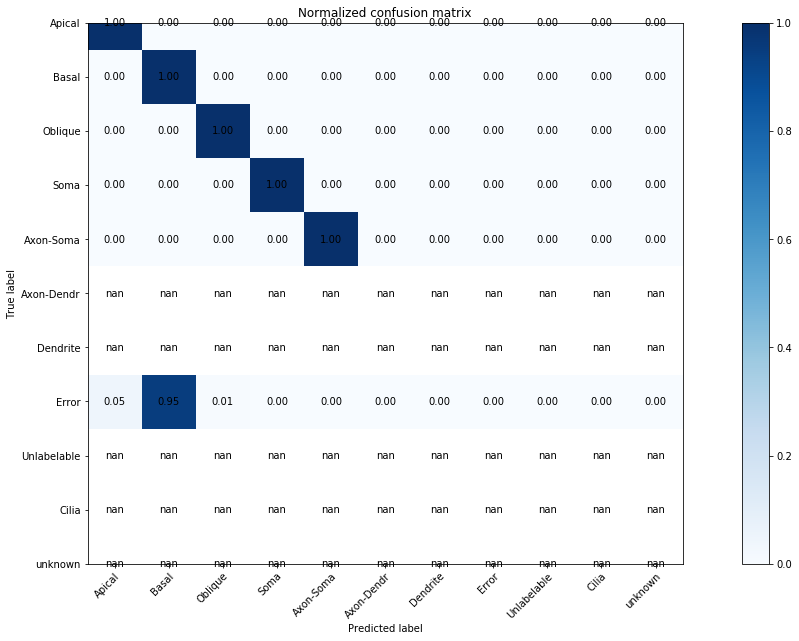

In [10]:
cp.plot_confusion_matrix_from_raw_data(y_true=actual_labels,
                                       y_pred=faces_labels_opt,
                                       classes=classes,
                                       cm_labels=cm_labels)

In [ ]:
#how to print out the actual labels
#export the labels
labels_opt = faces_labels_opt.astype("int")
np.savetxt("temp/" + str(key["segment_id"]) + '_optimized_output_labels.csv', labels_opt, fmt='%d', delimiter='\n')

In [ ]:
#change all of the labels that are above allowed value to unknown
faces_labels[faces_labels>=13] = 13

from collections import Counter
Counter(faces_labels)

In [ ]:
#change all of the labels that are above allowed value to unknown
faces_labels[faces_labels>=13] = 13

cp.plot_confusion_matrix_from_raw_data(y_true=actual_labels,
                                       y_pred=faces_labels,
                                       classes=classes,
                                       cm_labels=cm_labels)

In [ ]:
#how to print out the actual labels
#export the labels
labels = faces_labels.astype("int")
np.savetxt("temp/" + str(key["segment_id"]) + 'NOT_optimized_output_labels.csv', labels, fmt='%d', delimiter='\n')